In [156]:
# The goal of this nb is to create a ML model to predict the expected loss (for the insurance company) given an individual and their subsequent characteristics such as age, sex, smoking, etc. 

# ExpAmt fields – these values represent the expected claim amounts for the policy year based upon certain mortality tables (such as the 2015 vbt, for example).
    # The values depend upon various factors such as issue age, sex, smoker/non-smoker, and duration.
    # For example, suppose we had a policy issued on a 20-year-old male non-smoker that is now in its 10th policy year (duration = 10, and the insured is now 30 years old).
    # According to the 2015 vbt table, the expected death rate for such a person is 0.44 per 1000; said differently, you could say that such an individual has a 0.44/1000 = 0.00044 probability of dying that year.
    # If the policy were for 500,000, then our expected claim amount for the policy year would be 500,000 * 0.44 / 1000 = 220.
    # As you might expect, older individuals will typically have a higher probability of dying and thus higher expected claim amounts for the same policy size.
    # Similarly, different smoker status and/or sex will affect the expected claim amounts.

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import math
import seaborn as sns

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy import stats

In [158]:
# Bring in Data and Select Input and Output variable(s)

df0 = pd.read_csv(r'C:\Users\oakle\OneDrive\Documents\Code\Mortality\Mortality\Mort2020.csv')
df1 = pd.read_csv(r'C:\Users\oakle\OneDrive\Documents\Code\Mortality\Mortality\Mort2021.csv')
df2 = pd.read_csv(r'C:\Users\oakle\OneDrive\Documents\Code\Mortality\Mortality\Mort2022.csv')
df3 = pd.read_csv(r'C:\Users\oakle\OneDrive\Documents\Code\Mortality\Mortality\Mort2023.csv')

df = pd.concat([df0,df1,df2,df3], axis=0,ignore_index=True,)

df = df.drop_duplicates()

C:\Users\oakle\AppData\Local\Temp\ipykernel_21944\384676792.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df0 = pd.read_csv(r'C:\Users\oakle\OneDrive\Documents\Code\Mortality\Mortality\Mort2020.csv')
C:\Users\oakle\AppData\Local\Temp\ipykernel_21944\384676792.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(r'C:\Users\oakle\OneDrive\Documents\Code\Mortality\Mortality\Mort2021.csv')
C:\Users\oakle\AppData\Local\Temp\ipykernel_21944\384676792.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(r'C:\Users\oakle\OneDrive\Documents\Code\Mortality\Mortality\Mort2022.csv')
C:\Users\oakle\AppData\Local\Temp\ipykernel_21944\384676792.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv(r'C:\Users\oakle\OneDrive\Do

In [159]:
X = df[['CvgSexCode',
        'CvgIssueAge',
        'Duration',
        'AttainedAge',
        'PivotTobaccoCode',
        'UWClass',
        'MortExposureAmt',
        'TableRating'
        ]]
X

,CvgSexCode,CvgIssueAge,Duration,AttainedAge,PivotTobaccoCode,UWClass,MortExposureAmt,TableRating
0,M,33,20,52,S,ST,100000.000000,NaN
1,F,53,20,72,N,SN,5416.666667,NaN
2,F,52,20,71,N,SN,14166.666670,NaN
3,M,28,20,47,S,ST,16500.000000,NaN
4,M,52,20,71,S,ST,8041.666667,NaN
...,...,...,...,...,...,...,...,...
3324015,M,45,15,59,N,SN,100000.000000,B
3324016,M,26,19,44,N,SN,100000.000000,NaN
3324017,M,26,18,43,N,PN,250000.000000,NaN
3324018,M,36,16,51,S,PT,350000.000000,NaN


In [161]:
X.reset_index(inplace=True,drop=True)

map = {'SN': 1,
       'PN': 2,
       'SS': 3,
       'SP': 4,
       'ST': 5,
       'PP': 6,
       'PT': 7,
       'PS': 8
        }

for row in X.itertuples():


    index = row[0]
    
    # Convert sex_char to num
    gender = row.CvgSexCode
    if gender == 'M':
        X.at[index,'CvgSexCode'] = 0
    else: X.at[index,'CvgSexCode'] = 1

    # Convert smoker to num
    smoker = str(getattr(row,'PivotTobaccoCode'))
    if smoker == 'S':
        X.at[index,'PivotTobaccoCode'] = 1
    else: X.at[index,'PivotTobaccoCode'] = 0

    outlier = str(getattr(row,'TableRating'))

    if outlier != None:
        X = X.drop(index)

        
# X.drop(columns= 'TableRating',axis = 1)

# Convert UnderWritingClass to numeric 
X['UWClass'] = X['UWClass'].replace(map)
    


KeyboardInterrupt: 

In [149]:
print(X['TableRating'].value_counts())
X

Series([], Name: count, dtype: int64)


,CvgSexCode,CvgIssueAge,Duration,AttainedAge,PivotTobaccoCode,UWClass,MortExposureAmt,TableRating


In [142]:

y = df[['2015vbtExpAmt','2015vbtCompositeExpAmt']]
y

,2015vbtExpAmt,2015vbtCompositeExpAmt
1175,358.732099,555.819944
1179,364.400000,564.000000
4949,312.000000,171.750000
4961,725.000000,965.000000
6861,525.000000,770.250000
...,...,...
3316967,70.750000,70.750000
3322873,95.100000,95.100000
3322899,172.500000,172.500000
3322900,119.060000,119.060000


In [138]:
# Designate 80% of Data for training the model and 20% for Testing/Validation
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.8,test_size=.2,random_state=50)

# ------------------- FROM THIS POINT ON ALL TRAIN AND TEST DATA MUST BE SEPARATE. --------------------------------

ValueError: Found input variables with inconsistent numbers of samples: [0, 4505]

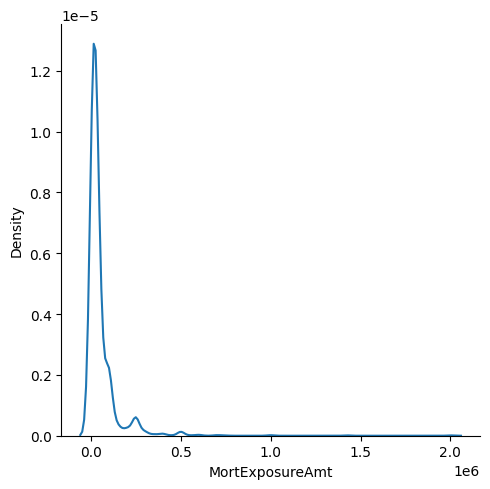

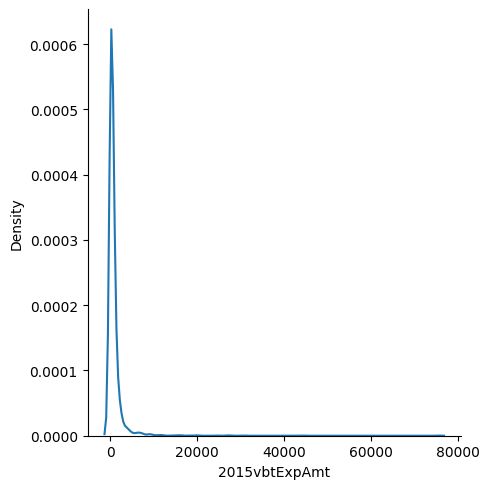

In [79]:
# Handle Outliers of 'MortExposureAmt', '2015vbtExpAmt', and '2015vbtExpNum' for Train and Test individually
# DO NOT MIX TRAIN AND TEST DATA
# MAKE SURE TO TRANSFER ALL TRANSFORMATIONS DONE TO TRAIN ONTO TEST

# Use this link for references: https://neuraldatascience.io/5-eda/data_cleaning.html


# Plot distributions
sns.displot(kind='kde',
           data=X_train,
           x='MortExposureAmt'
           )


sns.displot(kind='kde',
           data=y_train,
           x= '2015vbtExpAmt'
           )


plt.show()

#

In [44]:
# #Calculate the range of the outliers
# mea_q1 = X_train['MortExposureAmt'].quantile(0.25)
# mea_q3 = X_train['MortExposureAmt'].quantile(0.75)
# mea_iqr = mea_q3 - mea_q1
# mea_out_low = mea_q1 - 1.5 * mea_iqr
# mea_out_high = mea_q3 + 1.5 * mea_iqr

# vbtAMT_q1 = X_train['2015vbtExpAmt'].quantile(0.25)
# vbtAMT_q3 = X_train['2015vbtExpAmt'].quantile(0.75)
# vbtAMT_iqr = vbtAMT_q3 - vbtAMT_q1
# vbtAMT_out_low = vbtAMT_q1 - 1.5 * vbtAMT_iqr
# vbtAMT_out_high = vbtAMT_q3 + 1.5 * vbtAMT_iqr

# vbtNUM_q1 = X_train['2015vbtExpNum'].quantile(0.25)
# vbtNUM_q3 = X_train['2015vbtExpNum'].quantile(0.75)
# vbtNUM_iqr = vbtNUM_q3 - vbtNUM_q1
# vbtNUM_out_low = vbtNUM_q1 - 1.5 * vbtNUM_iqr
# vbtNUM_out_high = vbtNUM_q3 + 1.5 * vbtNUM_iqr

# y_q1 = y_train.quantile(0.25)
# y_q3 = y_train.quantile(0.75)
# y_iqr = y_q3 - y_q1
# y_out_low = y_q1 - 1.5 * y_iqr
# y_out_high = y_q3 + 1.5 * y_iqr

# # Convert y_train to pd.Dataframe
# y_train = pd.DataFrame(y_train)

# # Add outlier bool collumn for each variable
# X_train['mea_outliers_tukey'] = (X_train.loc[:,'MortExposureAmt'] < mea_out_low) | (X_train.loc[:,'MortExposureAmt'] > mea_out_high)

# X_train['vbtAMT_outliers_tukey'] = (X_train.loc[:,'2015vbtExpAmt'] < vbtAMT_out_low) | (X_train.loc[:,'2015vbtExpAmt'] > vbtAMT_out_high)

# X_train['vbtNUM_outliers_tukey'] = (X_train.loc[:,'2015vbtExpNum'] < vbtNUM_out_low) | (X_train.loc[:,'2015vbtExpNum'] > vbtNUM_out_high)

# y_train['outliers_tukey'] = (y_train < mea_out_low) | (y_train > mea_out_high)

# print(X_train.head)
# print()
# print(y_train.head)

In [45]:
# # Add Z score collumn for each variable that required outlier ellimination

# X_train['MortExposureAmt_Z'] = stats.zscore(X_train['MortExposureAmt'])
# X_train['2015vbtExpAmt_Z'] = stats.zscore(X_train['2015vbtExpAmt'])
# X_train['2015vbtExpNum_Z'] = stats.zscore(X_train['2015vbtExpNum'])

# X_train.head()

In [46]:
# y_train['Z_values'] = stats.zscore(y_train['MortDecAmt'])
# y_train

In [47]:
# # Add Collumn to check for outliers via Z score test
# z_thresh = 2.5

# X_train['MEA_outliers_z'] = np.abs(X_train['MortExposureAmt_Z']) > z_thresh

# X_train['vbtAMT_outliers_z'] = np.abs(X_train['2015vbtExpAmt_Z']) > z_thresh

# X_train['vbtNUM_outliers_z'] = np.abs(X_train['2015vbtExpNum_Z']) > z_thresh

# y_train['outliers_z'] = np.abs(y_train['Z_values']) > z_thresh

In [48]:
# # Plot the ratio of Outlier to non-outliers
# y_train['outliers_z'].value_counts().plot.pie(autopct = "%.2f")

In [49]:
# # Due to the data being human based It was decided that it would be best to leave the outliers in.

# # Remove outlier collumns

# X_train = X_train.drop(columns=['MEA_outliers_z',
#                                 'vbtAMT_outliers_z',
#                                 'vbtNUM_outliers_z',
#                                 'MortExposureAmt_Z',
#                                 '2015vbtExpAmt_Z',
#                                 '2015vbtExpNum_Z',
#                                 'mea_outliers_tukey',
#                                 'vbtAMT_outliers_tukey',
#                                 'vbtNUM_outliers_tukey'
#                                 ])

# y_train = y_train.drop(columns=['outliers_z',
#                                 'Z_values',
#                                 'outliers_tukey'
#                                 ])

# X_train

In [58]:
# Create Multicollinearity Matrix
# If num > .90 , Column x Row are collinear
X_train = pd.DataFrame(X_train)
# Put Y infront of X variables
Xy_collin = pd.concat([y_train['2015vbtExpAmt'] , X_train.drop(columns='CvgSexCode')], axis =1)

# Define collin as standard scaler - [See Sklearn docs for more info]
collin = StandardScaler()

# Fit collin
collin_fit = collin.fit(Xy_collin)

# Convert collin fit back to pd.Dataframe
df_collin = pd.DataFrame(collin_fit.transform(Xy_collin))
df_collin.columns = Xy_collin.columns
df_collin.index = Xy_collin.index

corr_m = df_collin.corr(method='pearson')

corr_m_abs = corr_m.abs()
corr_m_upper = corr_m_abs.where(
    np.triu(np.ones(corr_m_abs.shape), k=1).astype(bool))

corr_m_upper

,2015vbtExpAmt,CvgIssueAge,Duration,AttainedAge,PivotTobaccoCode,UWClass,MortExposureAmt
2015vbtExpAmt,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CvgIssueAge,NaN,NaN,0.229744,0.756053,0.131151,0.150184,0.132026
Duration,NaN,NaN,NaN,0.463304,0.095213,0.394528,0.255740
AttainedAge,NaN,NaN,NaN,NaN,0.183450,0.128568,0.292202
PivotTobaccoCode,NaN,NaN,NaN,NaN,NaN,0.695013,0.011766
UWClass,NaN,NaN,NaN,NaN,NaN,NaN,0.157847
MortExposureAmt,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
# Create Multicollinearity Matrix
# If num > .90 , Column x Row are collinear
X_train = pd.DataFrame(X_train)
# Put Y infront of X variables
Xy_collin = pd.concat([y_train['2015vbtCompositeExpAmt'] , X_train.drop(columns='CvgSexCode')], axis =1)

# Define collin as standard scaler - [See Sklearn docs for more info]
collin = StandardScaler()

# Fit collin
collin_fit = collin.fit(Xy_collin)

# Convert collin fit back to pd.Dataframe
df_collin = pd.DataFrame(collin_fit.transform(Xy_collin))
df_collin.columns = Xy_collin.columns
df_collin.index = Xy_collin.index

corr_m = df_collin.corr(method='pearson')

corr_m_abs = corr_m.abs()
corr_m_upper = corr_m_abs.where(
    np.triu(np.ones(corr_m_abs.shape), k=1).astype(bool))

corr_m_upper

,2015vbtCompositeExpAmt,CvgIssueAge,Duration,AttainedAge,PivotTobaccoCode,UWClass,MortExposureAmt
2015vbtCompositeExpAmt,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CvgIssueAge,NaN,NaN,0.229744,0.756053,0.131151,0.150184,0.132026
Duration,NaN,NaN,NaN,0.463304,0.095213,0.394528,0.255740
AttainedAge,NaN,NaN,NaN,NaN,0.183450,0.128568,0.292202
PivotTobaccoCode,NaN,NaN,NaN,NaN,NaN,0.695013,0.011766
UWClass,NaN,NaN,NaN,NaN,NaN,NaN,0.157847
MortExposureAmt,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<function matplotlib.pyplot.show(close=None, block=None)>

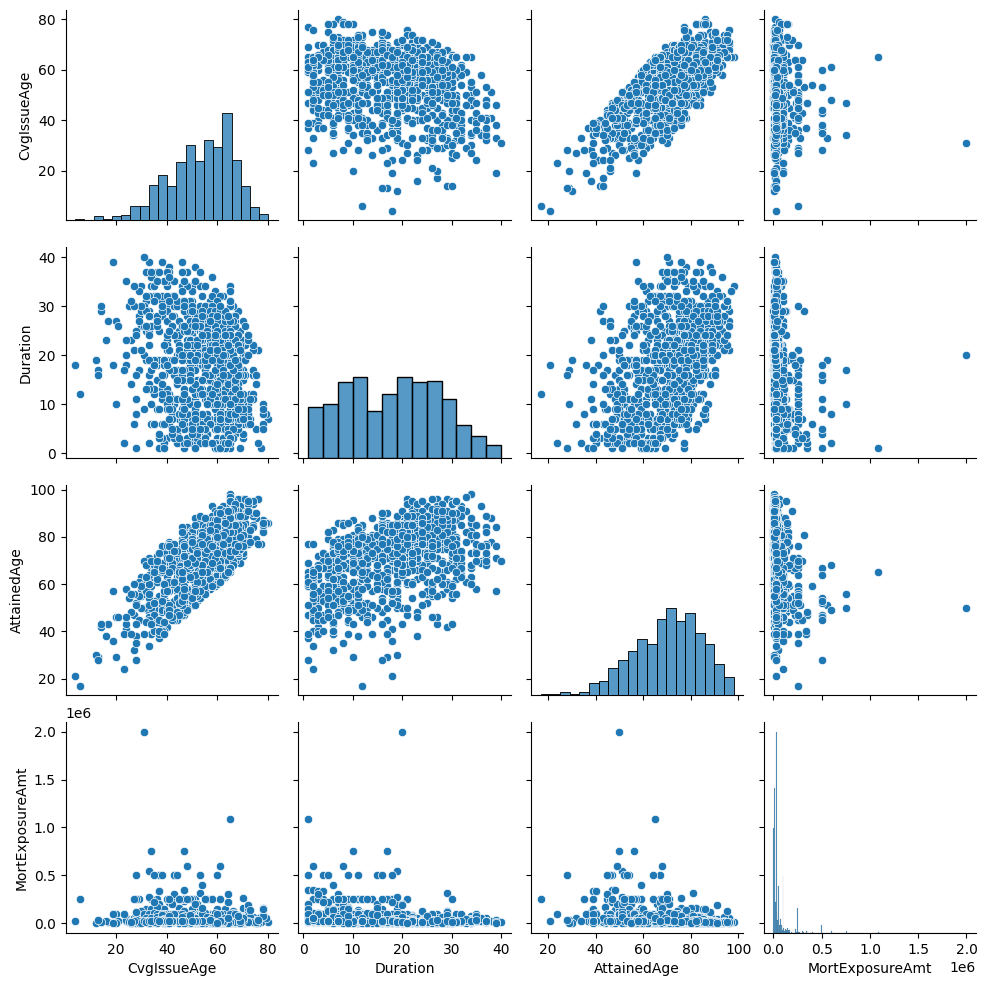

In [60]:
# Create Pairplot to check for weird Data

sns.pairplot(data=(X_test.drop(columns=['CvgSexCode','PivotTobaccoCode','UWClass'])))
plt.show

In [61]:
# Define the Plot and regress method
def plot_and_measure_regression(model_name :str , y_pred, y_true):

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    y_pred_sorted = np.sort(y_pred, axis=0)
    y_true_sorted = np.sort(y_true, axis=0)

    plt.figure
    plt.plot(y_pred_sorted, color = 'Blue', label = 'Predicted')
    plt.plot(y_true_sorted, color = 'Orange', label = 'Expected')
    plt.title(f'{model_name} Regression Chart')
    plt.xlabel('Sorted Index (meaningless)')
    plt.legend()
    plt.ylabel('MortDecAmount')
    plt.show()

# Define the Plot and classify method
def plot_and_measure_classification(model_name :str , y_pred, y_true):

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    y_pred_sorted = np.sort(y_pred, axis=0)
    y_true_sorted = np.sort(y_true, axis=0)

    plt.figure
    plt.plot(y_pred_sorted, color = 'Blue', label = 'Predicted')
    plt.plot(y_true_sorted, color = 'Orange', label = 'Expected')
    plt.title(f'{model_name} Regression Chart')
    plt.xlabel('Sorted Index (meaningless)')
    plt.legend()
    plt.ylabel('MortDecAmount')
    plt.show()

# Define Expected vs Predicted graph function
def exp_vs_pred(model_name :str, y_pred, y_true):

    plt.scatter(x= y_true, y= y_pred, color = 'Blue')
    plt.axline(xy1=(0,0), slope= 1, color = 'Orange',label = 'Ideal Line')
    plt.title(f'{model_name} Expected vs Predicted')
    plt.legend()
    plt.xlabel('y_true')
    plt.ylabel('y_pred')
    plt.show()



HGBT R2 Score = 258731.318564377
HGBT MSE Score = 0.9124560350254827


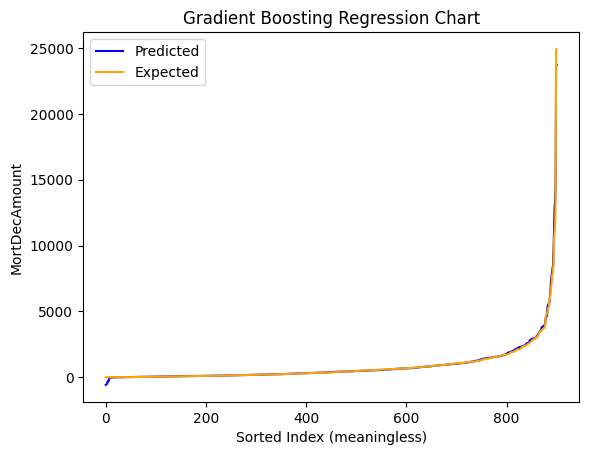

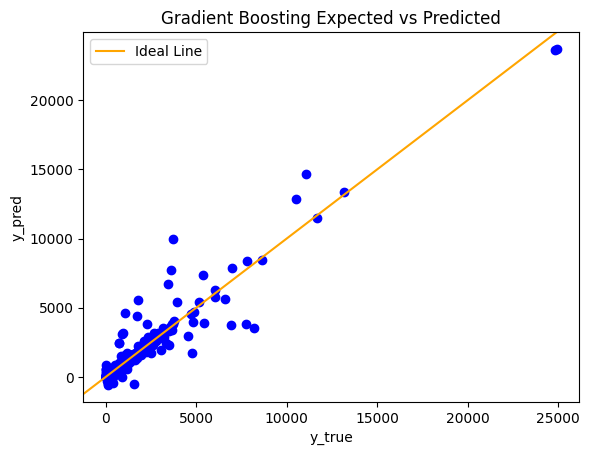

In [65]:
# ----------------------  Test 1 - Histogram Gradient Boosted Trees for 2015 Expected Amt ------------------------------------

# Define model and train using Train data only
HBGT_model = HistGradientBoostingRegressor(loss ='squared_error')

y_train = pd.DataFrame(y_train)

HBGT_model.fit(X_train,y_train['2015vbtExpAmt'])

# Use trained model to predict Y for validation
HGBT_y_pred = HBGT_model.predict(X_test)

# Evaluate Model using R^2 and MSE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

HGBT_r2 = mean_squared_error(y_true= y_test['2015vbtExpAmt'], y_pred=HGBT_y_pred)
HGBT_MSE = r2_score(y_true= y_test['2015vbtExpAmt'], y_pred=HGBT_y_pred)

print(f'HGBT R2 Score = {HGBT_r2}')
print(f'HGBT MSE Score = {HGBT_MSE}')

plot_and_measure_regression(model_name='Gradient Boosting',
                            y_pred= HGBT_y_pred,
                            y_true= y_test['2015vbtExpAmt']
                               )

exp_vs_pred(model_name= 'Gradient Boosting',
            y_pred= HGBT_y_pred,
            y_true= y_test['2015vbtExpAmt']
            )

HGBT R2 Score = 222796.2451898107
HGBT MSE Score = 0.9215510957854556


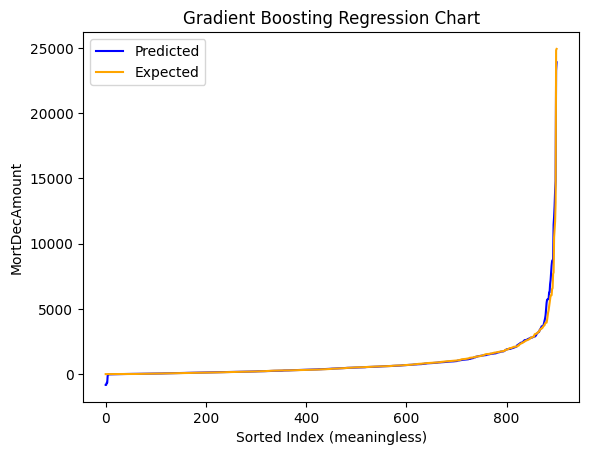

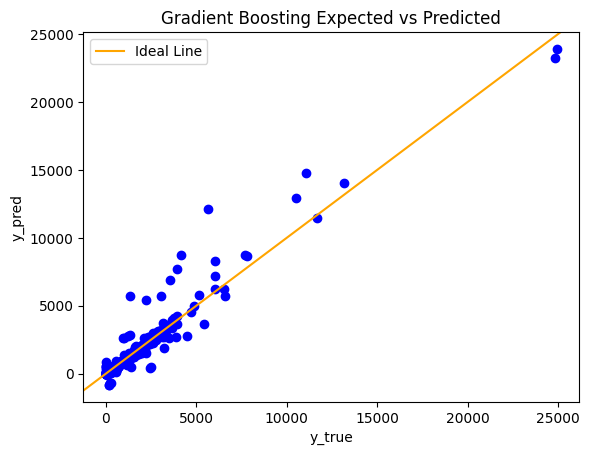

In [66]:
# ----------------------  Test 1 - Histogram Gradient Boosted Trees for 2015 Composite Expected Amt------------------------------------

# Define model and train using Train data only
HBGT_model = HistGradientBoostingRegressor(loss ='squared_error')

y_train = pd.DataFrame(y_train)

HBGT_model.fit(X_train,y_train['2015vbtCompositeExpAmt'])

# Use trained model to predict Y for validation
HGBT_y_pred = HBGT_model.predict(X_test)

# Evaluate Model using R^2 and MSE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

HGBT_r2 = mean_squared_error(y_true= y_test['2015vbtCompositeExpAmt'], y_pred=HGBT_y_pred)
HGBT_MSE = r2_score(y_true= y_test['2015vbtCompositeExpAmt'], y_pred=HGBT_y_pred)

print(f'HGBT R2 Score = {HGBT_r2}')
print(f'HGBT MSE Score = {HGBT_MSE}')

plot_and_measure_regression(model_name='Gradient Boosting',
                            y_pred= HGBT_y_pred,
                            y_true= y_test['2015vbtCompositeExpAmt']
                               )

exp_vs_pred(model_name= 'Gradient Boosting',
            y_pred= HGBT_y_pred,
            y_true= y_test['2015vbtCompositeExpAmt']
            )

In [25]:
# -----------------------  Test 2 - MLP Regressor (Neural Network)  -----------------------------

NN_model = MLPRegressor(solver='adam',early_stopping=True)

NN_model.fit(X_train,y_train)

NN_y_pred = NN_model.predict(X_test)

NN_r2 = mean_squared_error(y_true= y_test, y_pred=NN_y_pred)
NN_MSE = r2_score(y_true= y_test, y_pred=NN_y_pred)

print(f'NN R2 Score = {NN_r2}')
print(f'NN MSE Score = {NN_MSE}')

plot_and_measure_regression(model_name='Neural Network', 
                            y_pred=NN_y_pred,
                            y_true=y_test
                            )

exp_vs_pred(model_name='Neural Network',
            y_pred=NN_y_pred,
            y_true=y_test
            )

In [26]:
# ----------------------------------  Test 3 - Random Forest Regression  -------------------------------------

RFR_model = RandomForestRegressor()

RFR_model.fit(X_train,y_train)

RFR_y_pred = RFR_model.predict(X_test)

RFR_r2 = mean_squared_error(y_true= y_test, y_pred=RFR_y_pred)
RFR_MSE = r2_score(y_true= y_test, y_pred=RFR_y_pred)

print(f'NN R2 Score = {RFR_r2}')
print(f'NN MSE Score = {RFR_MSE}')

plot_and_measure_regression(model_name='Random Forest', 
                            y_pred=RFR_y_pred,
                            y_true=y_test
                            )

exp_vs_pred(model_name='Random Forest',
            y_pred=RFR_y_pred,
            y_true=y_test
            )


In [27]:
# Notes:

# It was discovered that a simple regression algorithm will likley not suffice to accurately predict the final amount to be paid. 

# Hypothetical solution: 
# Create a two part model with one part to classify each row as either a 0 or non-0. 
# Then using the non-0 entries create a model that predicts the non-0 values



# Next steps:
# Create a binary classification model (Likely logistic regression) to predict if any amount will be paid out. 
# Create a linear regression model (Likely Grad. Boosting)
# Combine the two models to accurately predict the payout amount of any given customer.

In [28]:
# Create boolean collumn in data that designates either 0 or non-0 payout amount
y = df['MortDecAmt']
y = pd.DataFrame(y)

is_zero = []

for row in range(y.shape[0]):
    if y['MortDecAmt'][row] == 0:
        is_zero.append(1)
    else:
        is_zero.append(0)

y.insert(loc=1,column='is_zero',value=is_zero)
y

,MortDecAmt,is_zero
0,0.0,1
1,0.0,1
2,0.0,1
3,0.0,1
4,0.0,1
...,...,...
3324015,0.0,1
3324016,0.0,1
3324017,0.0,1
3324018,0.0,1


In [29]:
X

,CvgSexCode,CvgIssueAge,Duration,AttainedAge,MortExposureAmt,PivotTobaccoCode,2015vbtExpAmt,2015vbtExpNum
0,0,33,20,52,46.415888,1,7.846013,0.147361
1,1,53,20,72,17.562137,0,3.777331,0.092832
2,1,52,20,71,24.196686,0,5.001222,0.111869
3,0,28,20,47,25.458217,1,3.790233,0.092832
4,0,52,20,71,20.034662,1,6.344667,0.137507
...,...,...,...,...,...,...,...,...
3324015,0,45,15,59,46.415888,0,6.979532,0.150369
3324016,0,26,19,44,46.415888,0,4.805896,0.000000
3324017,0,26,18,43,62.996052,0,6.423158,0.000000
3324018,0,36,16,51,70.472987,1,11.334102,0.000000


In [30]:
# Import a few Classification model options
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Split X and Y into Train and Test
X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=.8, test_size=.2, random_state=50)

LR_accuracy = 0.9911477668606086
LR_F1_score = 0.9955542058270499
0
1    664804
Name: count, dtype: int64
is_zero
1    658919
0      5885
Name: count, dtype: int64


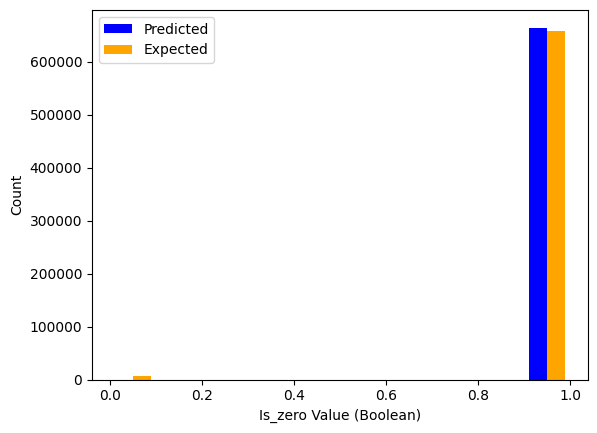

In [54]:
# ----------------------------- Part 1: Create logistic classification model ------------------------------
from sklearn.metrics import accuracy_score , f1_score

LR_model = LogisticRegression()

LR_model.fit(X=X_train, y= y_train['is_zero'])

LR_y_pred = LR_model.predict(X_test)
LR_y_pred = pd.DataFrame(LR_y_pred)


LR_accuracy = accuracy_score(y_true= y_test['is_zero'], y_pred= LR_y_pred.values)
LR_F1_score = f1_score(y_true= y_test['is_zero'], y_pred= LR_y_pred.values)

print(f'LR_accuracy = {LR_accuracy}')
print(f'LR_F1_score = {LR_F1_score}')


plt.figure()
plt.hist(x=[LR_y_pred[0],y_test['is_zero']],color=['Blue','Orange'],label=['Predicted','Expected'])
plt.legend()
plt.xlabel('Is_zero Value (Boolean)')
plt.ylabel('Count')
plt.show

pred_num_zeros = LR_y_pred.value_counts()
print(pred_num_zeros)

test_num_zeros = y_test['is_zero'].value_counts()
print(test_num_zeros)